In [ ]:
# pip install torchvision

In [ ]:
pip install keras

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

/Users/apple/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # prompt: code to connect google drive with colab

# from google.colab import drive
# drive.mount('/content/drive/')


In [3]:
class KneeDataset(Dataset):
    def __init__(self, data_path, categories, img_size=224):
        self.data_path = data_path
        self.categories = categories
        self.img_size = img_size
        self.data = []
        self.labels = []
        self.label_dict = {category: i for i, category in enumerate(categories)}
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  # Zoom augmentation
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self._load_data()

    def _load_data(self):
        for category in self.categories:
            folder_path = os.path.join(self.data_path, category)
            img_names = os.listdir(folder_path)
            for img_name in img_names:
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                self.data.append(img)
                self.labels.append(self.label_dict[category])

        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [4]:
# data_path = '/content/drive/MyDrive/knee-arthritis/Training/Training'
data_path = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training'
categories = ['1Doubtful', '4Severe', '2Mild', '0Normal', '3Moderate']
img_size = 224

dataset = KneeDataset(data_path, categories, img_size)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

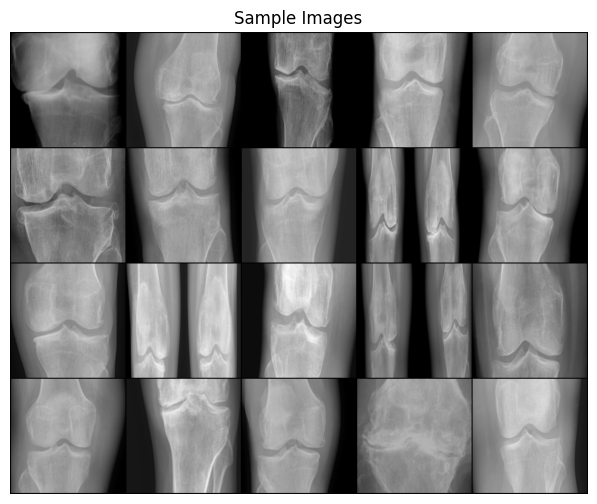

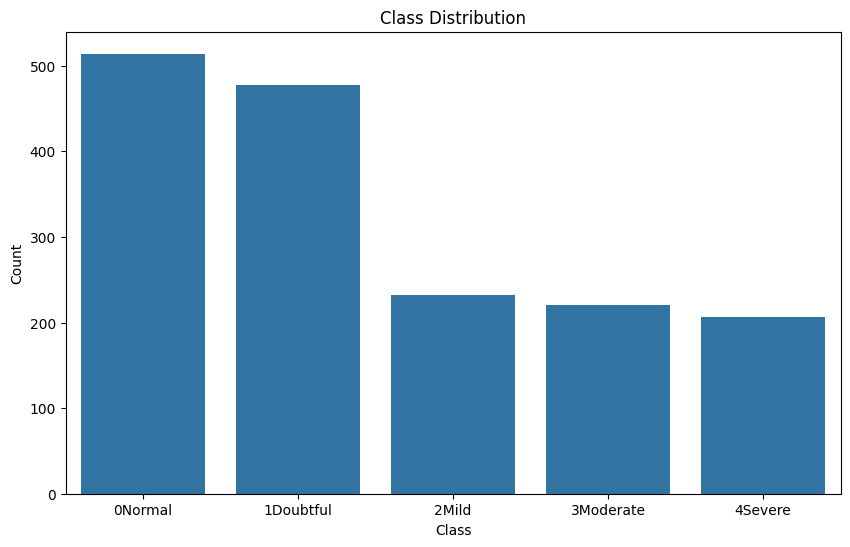

In [6]:
# EDA Code
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Assuming the dataset is in a directory structure suitable for torchvision's ImageFolder
# data_dir = '/content/drive/MyDrive/knee-arthritis/Training/Training'
data_dir = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training'
# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Display sample images
def show_images(images, labels, class_names):
    plt.figure(figsize=(12, 6))
    grid = make_grid(images, nrow=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()

# Get a batch of images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
images, labels = next(iter(data_loader))

# Show sample images
show_images(images, labels, dataset.classes)

# Class distribution
import seaborn as sns
import pandas as pd

labels_count = [0] * len(dataset.classes)
for _, label in dataset.samples:
    labels_count[label] += 1

df = pd.DataFrame({
    'Class': dataset.classes,
    'Count': labels_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Class Distribution')
plt.show()


In [ ]:
pip install imgaug opencv-python

In [11]:
import os
import cv2
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import numpy as np
from tqdm import tqdm

# Define the path to your original and new augmented datasets
original_dataset_path = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training' 
augmented_dataset_path =  '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training_augmented'

# Ensure the new directory structure
os.makedirs(augmented_dataset_path, exist_ok=True)

# Define augmentation techniques
augmenters = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Affine(rotate=(-20, 20))),   # Rotate images
    iaa.Sometimes(0.5, iaa.Affine(scale=(0.8, 1.2))),  # Zoom in/out
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),  # Add noise
])

# Count the number of files in each class
class_counts = {
    '0Normal': 514,
    '1Doubtful': 477,
    '2Mild': 232,
    '3Moderate': 221,
    '4Severe': 206
}

# Find the maximum number of files in any class
max_files = max(class_counts.values())

# Augment images for each class to match the maximum number of files
for class_name, count in class_counts.items():
    class_path = os.path.join(original_dataset_path, class_name)
    class_files = os.listdir(class_path)
    augmented_class_path = os.path.join(augmented_dataset_path, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    # Copy existing images to the new directory
    for file_name in class_files:
        img_path = os.path.join(class_path, file_name)
        img = cv2.imread(img_path)
        cv2.imwrite(os.path.join(augmented_class_path, file_name), img)

    # Calculate the number of augmentations needed
    augment_needed = max_files - count
    for i in tqdm(range(augment_needed), desc=f"Augmenting {class_name}"):
        img_idx = i % count
        img_path = os.path.join(class_path, class_files[img_idx])
        img = cv2.imread(img_path)
        aug_img = augmenters(image=img)
        aug_file_name = f"{os.path.splitext(class_files[img_idx])[0]}_aug_{i}.png"
        cv2.imwrite(os.path.join(augmented_class_path, aug_file_name), aug_img)

print("Data augmentation completed and class sizes equalized.")


Augmenting 0Normal: 0it [00:00, ?it/s]
Augmenting 4Severe: 100%|██████████| 308/308 [00:01<00:00, 213.17it/s]

Data augmentation completed and class sizes equalized.


In [ ]:
# import os
# import shutil
# # from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# # Path to the dataset
# data_dir = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training'  # Replace with the actual dataset path

# # Directory to save the augmented images
# augmented_data_dir = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training_augmented'  # Replace with the desired path
# os.makedirs(augmented_data_dir, exist_ok=True)

# # Function to count images in each class
# def count_images(data_dir):
#     class_counts = {}
#     for root, dirs, files in os.walk(data_dir):
#         if len(files) > 0:
#             class_name = os.path.basename(root)
#             class_counts[class_name] = len(files)
#     return class_counts

# # Get class distribution
# class_counts = count_images(data_dir)
# print(f'Class distribution before augmentation: {class_counts}')

# # Create directories for each class in the augmented dataset directory
# for class_name in class_counts.keys():
#     os.makedirs(os.path.join(augmented_data_dir, class_name), exist_ok=True)

# # Data augmentation parameters
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Determine the maximum number of images in any class
# target_count = max(class_counts.values())

# # Augment images to ensure each class has the same number of images
# for class_name, current_count in class_counts.items():
#     additional_images_needed = target_count - current_count

#     # Get all images of the current class
#     class_dir = os.path.join(data_dir, class_name)
#     class_images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.endswith('.png')]

#     i = 0
#     while additional_images_needed > 0:
#         for image_path in class_images:
#             if additional_images_needed <= 0:
#                 break

#             # Load image and apply augmentation
#             image = load_img(image_path)
#             x = img_to_array(image)
#             x = x.reshape((1,) + x.shape)

#             # Save augmented images
#             for batch in datagen.flow(x, batch_size=1, save_to_dir=os.path.join(augmented_data_dir, class_name), save_prefix='aug', save_format='png'):
#                 i += 1
#                 additional_images_needed -= 1
#                 if additional_images_needed <= 0:
#                     break

# # Copy original images to the augmented directory
# for class_name in class_counts.keys():
#     src_dir = os.path.join(data_dir, class_name)
#     dest_dir = os.path.join(augmented_data_dir, class_name)
#     for fname in os.listdir(src_dir):
#         if fname.endswith('.png'):
#             shutil.copy2(os.path.join(src_dir, fname), dest_dir)

# # Verify the class distribution
# augmented_class_counts = count_images(augmented_data_dir)
# print(f'Class distribution in augmented dataset: {augmented_class_counts}')


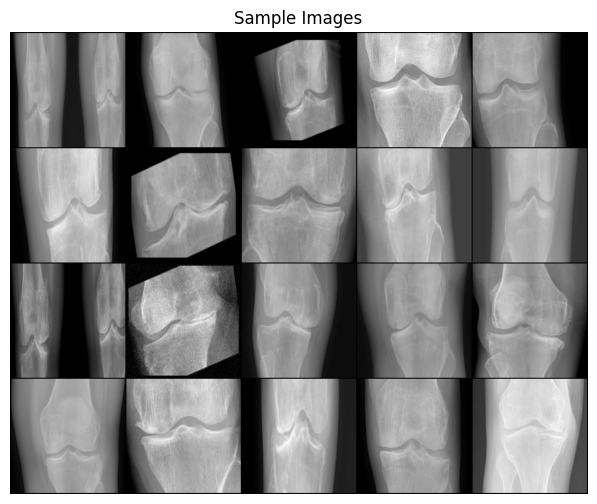

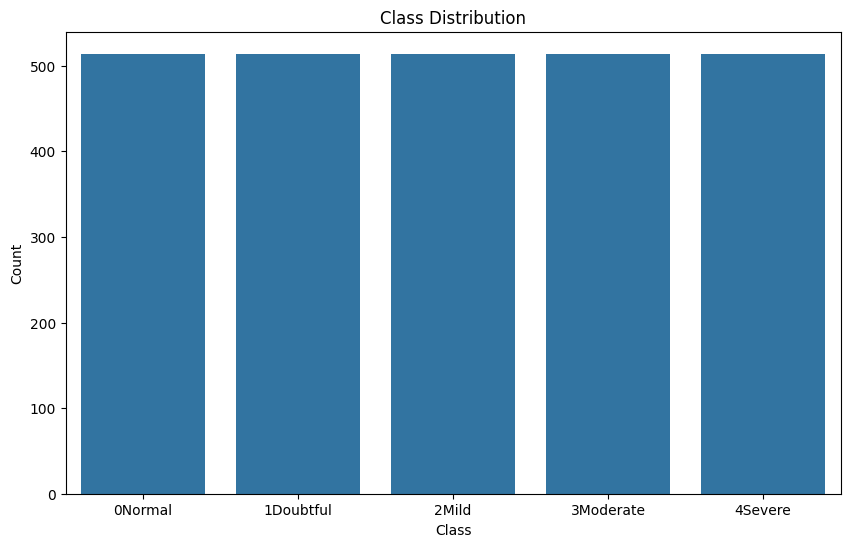

In [12]:
# EDA Code
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Assuming the dataset is in a directory structure suitable for torchvision's ImageFolder
# data_dir = '/content/drive/MyDrive/knee-arthritis/Training/Training'
data_dir = '/Users/apple/Desktop/PG/Summer-24/image-DL/knee-arthritis-detection-algo/data/Training_augmented'
# Data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Display sample images
def show_images(images, labels, class_names):
    plt.figure(figsize=(12, 6))
    grid = make_grid(images, nrow=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()

# Get a batch of images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
images, labels = next(iter(data_loader))

# Show sample images
show_images(images, labels, dataset.classes)

# Class distribution
import seaborn as sns
import pandas as pd

labels_count = [0] * len(dataset.classes)
for _, label in dataset.samples:
    labels_count[label] += 1

df = pd.DataFrame({
    'Class': dataset.classes,
    'Count': labels_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Class Distribution')
plt.show()


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Load the ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes
num_classes = len(categories)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

num_epochs = 100
best_accuracy = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Save the epoch loss

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    train_accuracies.append(accuracy)  # Save the epoch accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Best Accuracy: {best_accuracy:.4f}')

    scheduler.step()


In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Assuming 'train_losses' and 'train_accuracies' are lists storing loss and accuracy for each epoch

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [ ]:
# Best accuracy was 80.61 when using lr=1e-2, step size = 30 and no. of epochs = 25
# Best accuracy was 78.18 when using lr=1e-3, step size = 25 and no. of epochs = 25
# Best accuracy was 81.21 when using lr=1e-2, step size = 50 and no. of epochs = 20
# Best accuracy was 80.61 when using lr=1e-2, step size = 75 and no. of epochs = 20




In [ ]:
import random
import os
from PIL import Image
from torchvision import transforms

# Define the path to the training folder and the transformation
training_folder = '/content/drive/MyDrive/knee-arthritis/Training'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Get a list of all image files in the training folder
all_images = []
for label in os.listdir(training_folder):
    label_folder = os.path.join(training_folder, label)
    if os.path.isdir(label_folder):
        for img_file in os.listdir(label_folder):
            if img_file.endswith('.png'):
                all_images.append((label, os.path.join(label_folder, img_file)))

# Pick a random image
random_label, random_image_path = random.choice(all_images)

# Load the image and apply transformations
image = Image.open(random_image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)

# Get the model prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Check if the prediction is correct
predicted_label = predicted.item()
is_correct = predicted_label == int(random_label[0])

print(f"Random Image Path: {random_image_path}")
print(f"True Label: {random_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Correct: {is_correct}")


In [ ]:
# Final prediction code

def predict_and_display(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plotting confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Assuming 'test_loader' is the DataLoader for the test dataset
predict_and_display(model, test_loader, device)
